<a href="https://colab.research.google.com/github/jesvin1/EPAT_TIMESERIES/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

In [3]:
!pip install -q yfinance

# Importing the starndard libraries for time series **analysis**

In [0]:
# imports datetime for picking beginning and end dates for the analysis
import datetime
# imports yahoo finance for getting historical stock prices
import yfinance as yf
# imports pandas for dataframe manipulation
import pandas as pd
# imports numpy
import numpy as np
# for data visualization
import matplotlib as mpl
# for changing the plot size in the Jupyter Notebook output
%matplotlib inline
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)
# for shorter lines with plotting
from matplotlib import pyplot as plt
# to hide warning messages
import warnings
warnings.filterwarnings('ignore')
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import coint

# sets the sample period as 5 years back from 09/12/2019
end = datetime.datetime(2019, 9, 12)
start = end - datetime.timedelta(days = 7*365)


# Importing libraries for the Kears

In [13]:
!pip show tensorflow

Name: tensorflow
Version: 2.0.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: absl-py, six, termcolor, tensorboard, grpcio, wheel, numpy, opt-einsum, keras-applications, protobuf, tensorflow-estimator, astor, gast, keras-preprocessing, google-pasta, wrapt
Required-by: stable-baselines, magenta, fancyimpute


In [0]:
!pip install -q google-auth

In [0]:
!pip install -q grpcio

In [12]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [0]:
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [0]:
def tsplot(y, lags=None, figsize=(10, 8), style='seaborn-bright'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax, linewidth=1.5)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    
    return

In [0]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True, test_type='adfuller'):
        
        if test_type=='adfuller':
            
            #Dickey-Fuller test:
            adfTest = adfuller(timeseries, autolag='AIC')

            self.pValue = adfTest[1]

            if (self.pValue<self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False

            if printResults:
                dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

                #Add Critical Values
                for key,value in adfTest[4].items():
                    dfResults['Critical Value (%s)'%key] = value

                print('####################################Augmented Dickey-Fuller Test Results:####################################')
                print(dfResults)
                print("Is the time series stationary? {0}".format(sTest.isStationary))
        if test_type =='adfuller':
            
            #Kwiatkowski-Phillips-Schmidt-Shin test for stationarity:
            kpssTest = kpss(timeseries)

            self.pValue = kpssTest[1]

            if (self.pValue<self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False

            if printResults:
                kpssResults = pd.Series(kpssTest[0:4], index=['KPSS Test Statistic','P-Value','# Lags Used','# Observations Used'])

                '''#Add Critical Values
                for key,value in kpssTest[4].items():
                    dfResults['Critical Value (%s)'%key] = value'''

                print('####################################KPSS Test Results:####################################')
                print(kpssResults)
                print("Is the time series stationary? {0}".format(sTest.isStationary))

# Getting the data for time series analysis

In [0]:
# gets the closing price fo HDFC for the past 7 years
my_stock = yf.Ticker('HDFCBANK.NS')
my_stock = pd.DataFrame(my_stock.history(start = start, end = end)['Close'])
my_stock = my_stock.rename(str.lower, axis = 'columns')

In [19]:
my_stock.head()

,close
Date,
2012-09-13,268.92
2012-09-14,275.01
2012-09-17,273.01
2012-09-18,271.73
2012-09-20,272.38


# **Statistical Normality Test (D’Agostino’s K² Test)** 

1.   p <= alpha: reject H0, not normal.
2.   p > alpha: fail to reject H0, normal.





In [21]:
stat, p = scs.normaltest(my_stock.close)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=825.443, p=0.000
Data does not look Gaussian (reject H0)


In [22]:
sTest = StationarityTests()
#my_stock['returns']=my_stock.close.pct_change(1)
sTest.ADF_Stationarity_Test(my_stock.close.dropna(), printResults = True)

####################################Augmented Dickey-Fuller Test Results:####################################
ADF Test Statistic         0.408606
P-Value                    0.981814
# Lags Used                2.000000
# Observations Used     1715.000000
Critical Value (1%)       -3.434169
Critical Value (5%)       -2.863227
Critical Value (10%)      -2.567668
dtype: float64
Is the time series stationary? False
####################################KPSS Test Results:####################################
KPSS Test Statistic                                              6.38886
P-Value                                                             0.01
# Lags Used                                                           25
# Observations Used    {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
dtype: object
Is the time series stationary? True


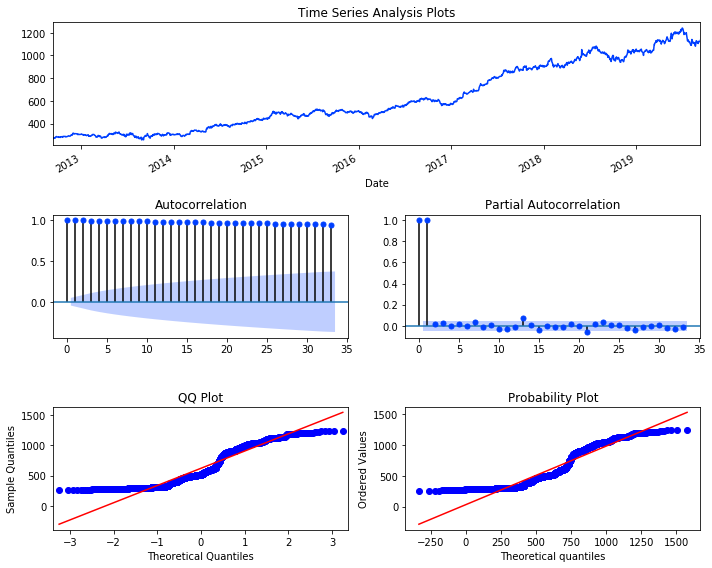

In [23]:
tsplot(my_stock.close)

# Calculating Kurtosis and Skewness, to determine if the data distribution departs from the normal distribution

Kurtosis of normal distribution: -1.120727538406099
Skewness of normal distribution: 0.5069623720320772


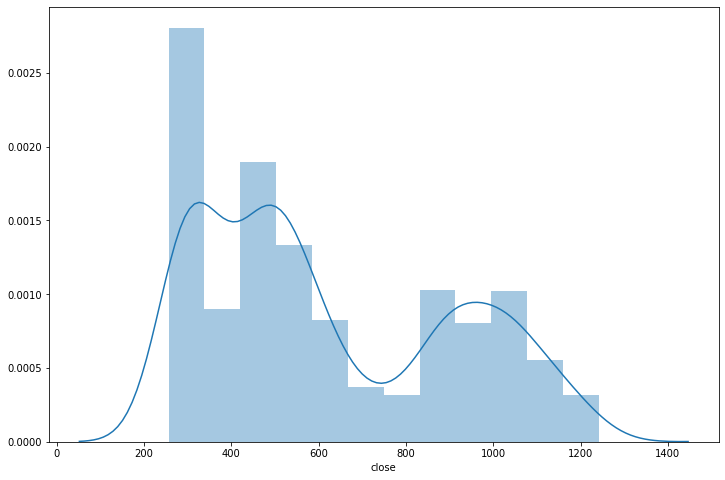

In [27]:
sns.distplot(my_stock.close);
print( 'Kurtosis of normal distribution: {}'.format(scs.kurtosis(my_stock.close)))
print( 'Skewness of normal distribution: {}'.format(scs.skew(my_stock.close)))

Kurtosis: describes heaviness of the tails of a distribution
Normal Distribution has a kurtosis of close to 0. If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is less than zero.


Skewness: measures asymmetry of the distribution
If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater is .5.

In [0]:
from scipy import stats

In [0]:
x=np.asarray(ts['log_return'].dropna())
stats.jarque_bera(x)
#Since the p-value is less than any significant level of aplha, 
#we can reject the Null and conclude that data do not follow a normal distribution.

(1297.7536040583857, 0.0)

In [0]:
stats.kurtosis(x)
#Is greater than 3. Hence, the return distribution is called “leptokurtic”.

3.534754356097589

In [0]:
!pip install yfinance